In [ ]:
!pwd
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

/content


In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification
!unzip /content/ham1000-segmentation-and-classification.zip

In [ ]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_2kq6ddl
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-_2kq6ddl
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=64d3147c4f5ea2a5ab52718aadb755c8d9d72bc06a7edabc52e26e65b82751ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-tv73elyn/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 8.2 MB/s 


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import Image
from tensorflow import keras
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.pyplot import imshow

In [ ]:
import data_helper as dh
import model_build_helper as mbh

In [ ]:
df_o = pd.read_csv('https://raw.githubusercontent.com/albert6051/DSEI210-Final-Project--Skinjob/main/data/raw/HAM10000_metadata.csv')
image_path = r'../content/images/'

In [ ]:
h = 240
w = 240
aug_targets = ['mel', 'bcc']
aug_count = 0
aug_size = 0

train_set, test_set, class_weight, labels = dh.prep_pipeline1(df_o, image_path, 1500, h, w, aug_targets, aug_count, aug_size)

In [ ]:
X_train = train_set[0]
y_train = train_set[2]

X_test = test_set[0]
y_test = test_set[2]

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3367, 240, 240, 3) (1443, 240, 240, 3) (3367, 7) (1443, 7)


In [ ]:
histories = {}

channels = 3
img_shape = (h, w, channels)

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto')      
  ]

In [ ]:
model = mbh.model_builder(img_shape, 288, 0.001)

27033600/27018416 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(X_train,
                    y_train, 
                    epochs=100, 
                    validation_split=0.2, 
                    callbacks=get_callbacks(),
                    class_weight=class_weight)

Epoch 1/100
85/85 [==============================] - 63s 425ms/step - loss: 13.2193 - accuracy: 0.3520 - val_loss: 11.2468 - val_accuracy: 0.3680 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 32s 382ms/step - loss: 10.7491 - accuracy: 0.5848 - val_loss: 10.3513 - val_accuracy: 0.4006 - lr: 0.0010
Epoch 3/100
85/85 [==============================] - 32s 382ms/step - loss: 9.6770 - accuracy: 0.6821 - val_loss: 9.5160 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 4/100
85/85 [==============================] - 32s 382ms/step - loss: 8.9297 - accuracy: 0.7482 - val_loss: 8.8319 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 5/100
85/85 [==============================] - 32s 378ms/step - loss: 8.2531 - accuracy: 0.7854 - val_loss: 8.2620 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 32s 382ms/step - loss: 7.6750 - accuracy: 0.8281 - val_loss: 7.7644 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 3

In [ ]:
model.save('/content/')

INFO:tensorflow:Assets written to: /content/assets


In [ ]:
histories['EfficientNetB1'] = history

(0.0, 20.0)

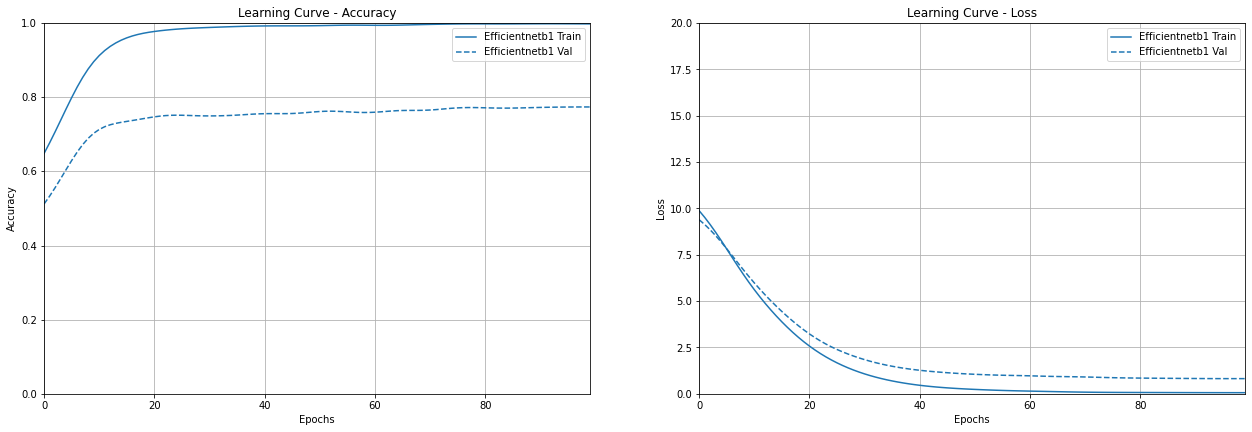

In [ ]:
plt.figure(figsize=(45,15))
plt.subplot(2,4,1)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Accuracy") 
plt.ylim([0, 1])
plt.subplot(2,4,2)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)
plt.title("Learning Curve - Loss") 
plt.ylim([0, 20])

In [ ]:
pred=model.predict(X_test)
y_pred=[]
for p in pred:
  pred_index=np.argmax(p)
  y_pred.append(pred_index)
y_ture=[]
for p in y_test:
  pred_index=np.argmax(p)
  y_ture.append(pred_index)
y_true = np.array(y_ture)
y_pred = np.array(y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

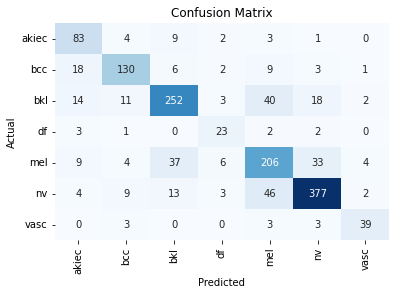

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(7)+0.5, labels, rotation= 90)
plt.yticks(np.arange(7)+0.5, labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [ ]:
clr = classification_report(y_true, y_pred, target_names=labels)
print("Classification Report:")
print("=====================================================")
print(clr)

Classification Report:
              precision    recall  f1-score   support

       akiec       0.63      0.81      0.71       102
         bcc       0.80      0.77      0.79       169
         bkl       0.79      0.74      0.77       340
          df       0.59      0.74      0.66        31
         mel       0.67      0.69      0.68       299
          nv       0.86      0.83      0.85       454
        vasc       0.81      0.81      0.81        48

    accuracy                           0.77      1443
   macro avg       0.74      0.77      0.75      1443
weighted avg       0.78      0.77      0.77      1443



In [ ]:
model.evaluate(X_test, y_test)

46/46 [==============================] - 3s 64ms/step - loss: 0.9681 - accuracy: 0.7692


[0.9681063890457153, 0.7692307829856873]

In [ ]:
from google.colab import files
files.download('/content/saved_model.pb') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>